In [1]:
import itertools
import pytz

import numpy as np
from tables import *
from datetime import datetime, timedelta

import pandas as pd

from skyfield import api
from skyfield.sgp4lib import EarthSatellite
from skyfield.framelib import itrs

ts = api.load.timescale()

In [2]:
h5file = open_file("/data/Indexed_TLE/reduced.h5", mode="r+")
tle_table = h5file.root.tle_sorted

# TODO: Precompute this. it takes a while to scrape the whole col...
all_ids = set(tle_table.cols.norad_id)
len(all_ids)

19404

In [31]:
def tle_dataframe(records):
    return pd.DataFrame.from_records(records, columns=["epoch", "norad_id", "tle1", "tle2"])

def get_all_tles(norad_id: int):
    """
    Return a list of record types structured as
    (norad_id: int, epoch_time: float, tle_line_1: bytes, tle_line_2: bytes)
    """
    records = tle_table.read_where("norad_id=={}".format(norad_id))
    # Sort records based on time
    return tle_dataframe(sorted(records, key=lambda row: row[0]))


two_weeks_td = timedelta(days=14)

class TLEManager:
    def __init__(self, norad_id: int):
        self.records = get_all_tles(norad_id)
        
    def get_known_timespan(self):
        """
        Return datetimes corresponding to the first and last TLE epoch values
        in our record set
        """
        times = self.records.epoch.to_numpy()
        return times[0], times[-1]
    
    def get_tle_times(self):
        return self.records.epoch.to_numpy()
    
    def get_compute_windows(self):
        """
        Return a dict which maps a tuple of epoch times, to a pair of TLE entries
        
        {
          (start_epoch, end_epoch) : (tle1, tle2)
        }
        """
        times = self.get_tle_times()
        times_dt = [datetime.utcfromtimestamp(t) for t in times]
        ntle = times.shape[0]
        
        windows = {}
        for i in range(ntle):
            # TODO(meawoppl) gross, numpify me better
            
            if i == 0:
                start = times[0]
            else:
                # TLE Gap Check
                if (times_dt[i] - times_dt[i-1]) > two_weeks_td:
                    start = (times_dt[i] - two_weeks_td).timestamp()
                else:
                    start = (times[i-1] + times[i]) /2
                
            
            if i == ntle-1:
                end = times[-1]
            else:
                if (times_dt[i+1] - times_dt[i]) > two_weeks_td:
                    end = (times_dt[i+1] + two_weeks_td).timestamp()
                else:
                    end = (times[i] + times[i+1]) / 2
        
            if (end - start) >  two_weeks_td.total_seconds():
                continue
        
            # NOTE(meawoppl) add holes to match AIS data somewhere in here....
            windows[(int(round(start)), int(round(end)))] = self.records.tle1[i], self.records.tle2[i]
        
        return windows
    
    def _epoch_to_julian(selt, time: float) -> float:
        return ts.from_datetime(datetime.utcfromtimestamp(time).replace(tzinfo=pytz.utc)).tt
    
    def compute_lat_long_dist(self, start_epoch: int, end_epoch: int, tle1, tle2):
        # Convert the start and end into julian
        start_time_j = self._epoch_to_julian(start_epoch)
        end_time_j = self._epoch_to_julian(end_epoch)
        n_time_steps = int(round((end_epoch - start_epoch) / 60))
        julian_times = ts.tt_jd(np.linspace(start_time_j, end_time_j, n_time_steps))
        epoch_times = np.linspace(start_epoch, end_epoch, n_time_steps)
        print(julian_times)
        sat = EarthSatellite(tle1.decode(), tle2.decode())
        lats, longs, dists = sat.at(julian_times).frame_latlon(itrs)
        return epoch_times, lats, longs, dists


In [32]:
tlem = TLEManager(list(all_ids)[-300])

In [33]:
windows = tlem.get_compute_windows()

<Time tt=[2454821.3259859257 ... 2454821.5858817594] len=374>
<Time tt=[2454821.5858817594 ... 2454822.3284280556] len=1069>
<Time tt=[2454822.3284280556 ... 2454823.070985926] len=1069>
<Time tt=[2454823.070985926 ... 2454824.0734164813] len=1444>
1229790631.1 1230051746.9


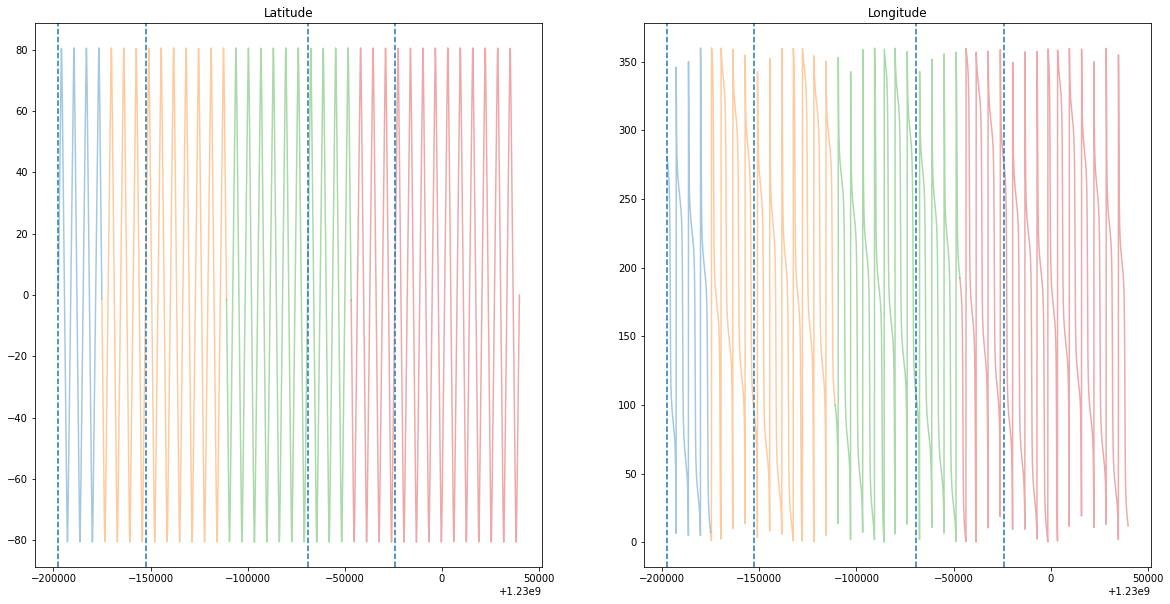

In [37]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20,  10)


for i, ((start, end), (tle1, tle2)) in enumerate(windows.items()):
    times, lats, longs, alts = tlem.compute_lat_long_dist(start, end, tle1, tle2)

    ax1.set_title("Latitude")
    ax1.plot(times, lats.degrees, alpha=0.4)

    ax2.set_title("Longitude")
    ax2.plot(times, longs.degrees, alpha=0.4)
    
    if i > 2:
        break

xmin, xmax = ax1.get_xlim()
print(xmin, xmax)
for t in tlem.get_tle_times():
    if(t>xmin and t < xmax):
        ax1.axvline(t, ls="--")
        ax2.axvline(t, ls="--")




In [ ]:
lla = np.hstack((lats.degrees, longs.degrees, alts.km))
lla.dump("plausible.np")

In [ ]:
datetime.datetime

In [ ]:
def get_tracks_for_timerange(satellite: int, start: datetime, end: datetime):
    """
    Return a listing of active satellites and positions that spans `start` to `end`
    datetimes. The arrays returned will have `times` elements, which correspond to the
    number of integer minuted between the starting points of the two arrays.
    
    This returns an array:
    @returns np.array (times, 3)
    
    """
    pass
    
    